In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
day_price_0_df = pd.read_csv("../round-1-island-data-bottle/prices_round_1_day_0.csv", delimiter=";")
day_price_m1_df = pd.read_csv("../round-1-island-data-bottle/prices_round_1_day_-1.csv", delimiter=";")
day_price_m2_df = pd.read_csv("../round-1-island-data-bottle/prices_round_1_day_-2.csv", delimiter=";")

# merge all the dataframes
merged_df = pd.concat([day_price_0_df, day_price_m1_df, day_price_m2_df])


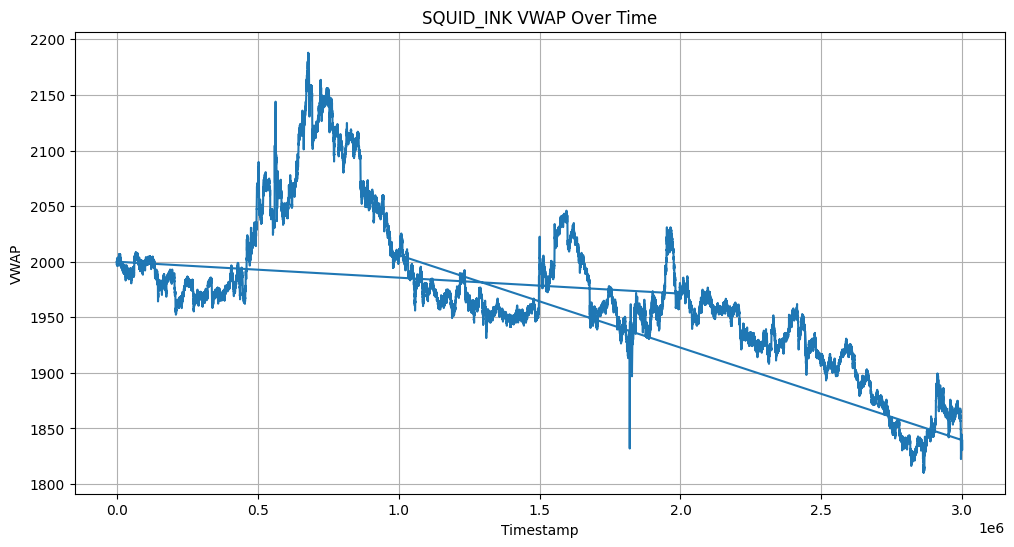

In [20]:
# isolate the squid ink data - create a copy to avoid the warning
squid_ink_df = merged_df[merged_df["product"] == "SQUID_INK"].copy()

squid_ink_df['continuous_timestamp'] = squid_ink_df['timestamp'] + 1e6 * (2 - abs(squid_ink_df['day']))


# Calculate VWAP by only considering valid price-volume pairs
bid_value = sum(
    squid_ink_df[f"bid_price_{i}"] * squid_ink_df[f"bid_volume_{i}"]
    for i in range(1, 4)
    if not (pd.isna(squid_ink_df[f"bid_price_{i}"]).any() or 
            pd.isna(squid_ink_df[f"bid_volume_{i}"]).any())
)

ask_value = sum(
    squid_ink_df[f"ask_price_{i}"] * squid_ink_df[f"ask_volume_{i}"]
    for i in range(1, 4)
    if not (pd.isna(squid_ink_df[f"ask_price_{i}"]).any() or 
            pd.isna(squid_ink_df[f"ask_volume_{i}"]).any())
)

total_volume = sum(
    squid_ink_df[f"{side}_volume_{i}"]
    for side in ["bid", "ask"]
    for i in range(1, 4)
    if not (pd.isna(squid_ink_df[f"{side}_price_{i}"]).any() or 
            pd.isna(squid_ink_df[f"{side}_volume_{i}"]).any())
)

# Calculate VWAP
squid_ink_df.loc[:, "vwap"] = (bid_value + ask_value) / total_volume

# Plot
plt.figure(figsize=(12, 6))
plt.plot(squid_ink_df["continuous_timestamp"], squid_ink_df["vwap"])
plt.title("SQUID_INK VWAP Over Time")
plt.xlabel("Timestamp")
plt.ylabel("VWAP")
plt.grid(True)
plt.show()


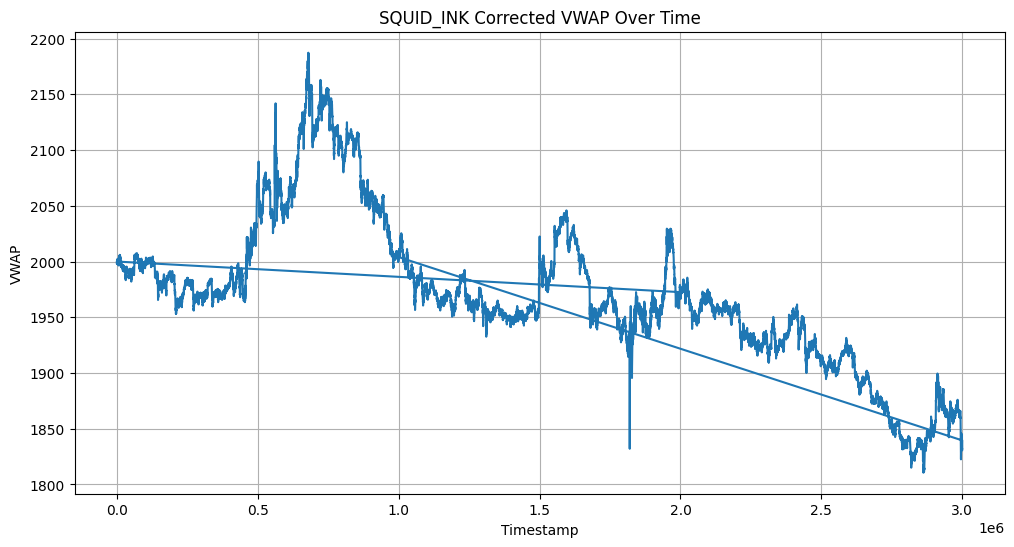

/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic


In [ ]:
# now use pmd to fit a SARIMA
# First let's fix the VWAP calculation to be per-row rather than aggregated
def calculate_vwap_row(row):
    bid_value = sum(
        row[f"bid_price_{i}"] * row[f"bid_volume_{i}"]
        for i in range(1, 4)
        if pd.notna(row[f"bid_price_{i}"]) and pd.notna(row[f"bid_volume_{i}"])
    )
    
    ask_value = sum(
        row[f"ask_price_{i}"] * row[f"ask_volume_{i}"]
        for i in range(1, 4)
        if pd.notna(row[f"ask_price_{i}"]) and pd.notna(row[f"ask_volume_{i}"])
    )
    
    total_volume = sum(
        row[f"{side}_volume_{i}"]
        for side in ["bid", "ask"]
        for i in range(1, 4)
        if pd.notna(row[f"{side}_price_{i}"]) and pd.notna(row[f"{side}_volume_{i}"])
    )
    
    return (bid_value + ask_value) / total_volume if total_volume > 0 else np.nan

# Recalculate VWAP properly
squid_ink_df['vwap'] = squid_ink_df.apply(calculate_vwap_row, axis=1)

# Plot the corrected VWAP
plt.figure(figsize=(12, 6))
plt.plot(squid_ink_df["continuous_timestamp"], squid_ink_df["vwap"])
plt.title("SQUID_INK Corrected VWAP Over Time")
plt.xlabel("Timestamp")
plt.ylabel("VWAP")
plt.grid(True)
plt.show()

# Now fit SARIMA model using pmdarima
import pmdarima as pm

# Create the SARIMA model
model = pm.auto_arima(squid_ink_df['vwap'].dropna(),
                     start_p=1, start_q=1,
                     test='adf',
                     max_p=3, max_q=3,
                     m=12,  # frequency for seasonal differencing
                     start_P=0, seasonal=True,
                     d=1, D=1, # difference order
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)

print(model.summary())

# Plot diagnostics
model.plot_diagnostics(figsize=(12, 8))
plt.show()
